## Kelly Criterion 
[(ref)](https://medium.com/@The-Quant-Trading-Room/the-ultimate-trading-strategy-how-to-combine-kelly-criteria-and-monte-carlo-simulation-d9ce8cc2c2bc)
Let $f$ be the percentage of total capital one decides to bet and $1-f$ be the percentage of the capital to be invested to a bank with interest rate $r>0$. Suppose the return rate $X$ follows $\mathcal{N}(\mu,\sigma^2)$,
we consider the maximization of expected log wealth over the fraction $f$ and the optimal fraction:
$$
\sup_{f \in \mathbb{R}}E(\ln(1+fX+ (1-f)r)) \; \Rightarrow \; f^* = \frac{\mu-r}{\sigma^2}
$$
We can run simulation for the price path and see the performance of Kelly criterion for long peroids
or run the backtest for the given input data. We can also include some conditions , e.g fractional Kelly(only invest $\alpha f^*$ for some $\alpha \in (0,1)$ ) or leverage limit ( $f^* \wedge k$ for some integer $k>1$).

input : log return $x_t$ from data or random generated, output: growth rate sequence 
$\{\prod_{s=1}^t(1+f^* x_s + (1-f^*)r)\}_{t \geq 1}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def kelly(return_array,rate_array,kelly_cap,kelly_frac):
    mu = np.mean(return_array)
    var = np.var(return_array)
    if kelly_cap == False: #no restricion for leverage
        f_opt = (mu-rate_array[s])/var *kelly_frac  #allow shorting , f_opt can be negative
    else:
        f_opt = min((mu-rate_array[s])/var ,kelly_cap)*kelly_frac 
    wealth_array = np.ones(len(return_array)+1)
    growth_array = np.zeros_like(return_array)
    for s in range(len(return_array)):
        growth_array[s] = (1+f_opt*return_array[s] + (1-f_opt)*rate_array[s])
        wealth_array[s+1] = wealth_array[s]*growth_array[s]
    return wealth_array,growth_array

### Simulation
We consider different fractional Kelly criterions and compare them and other strategies like buy and hold or arbitrary chosen weight for rebalancing.


Suppose the interest rate for one year is $4\%$, mean of
daily return is $0$ , standard deviation of daily return is $0.01$. We run the Kelly criterions daily for $10000$ days (~ $27$ years) with $\alpha = 1 , 0.8 , 0.5 , 0.2$, buying $50\%$ and holds, buying $100\%,50\% ,0\% $ and
rebalancing.

B&H =$\{\frac{1}{2} \prod_{s=1}^t (1+x_s) + \frac{1}{2}\prod_{s=1}^t (1+r)\}_{t\geq 1}$ 

arbitrary weight = $\{\prod_{s=1}^t(1+\theta x_s + (1-\theta)r)\}_{t \geq 1}$ for some $\theta \in [0,1]$

In [2]:
def BnH(return_array,rate_array):
    wealth_array = np.ones(len(return_array)+1)
    stock=0.5
    bank=0.5
    growth_array = np.zeros_like(return_array)
    for s in range(len(return_array)):
        stock=stock*(1+return_array[s])
        bank= bank*(1+rate_array[s])
        wealth_array[s+1]= stock+bank
        growth_array[s] = wealth_array[s+1]/wealth_array[s]
    return wealth_array,growth_array
def arbitrary(return_array,rate_array,ratio):
    wealth_array = np.ones(len(return_array)+1)
    growth_array = np.zeros_like(return_array)
    for s in range(len(return_array)):
        growth_array[s] = (1+ratio*return_array[s] + (1-ratio)*rate_array[s])
        wealth_array[s+1] = wealth_array[s]*growth_array[s]
    return wealth_array,growth_array

#### Plot of each strategy

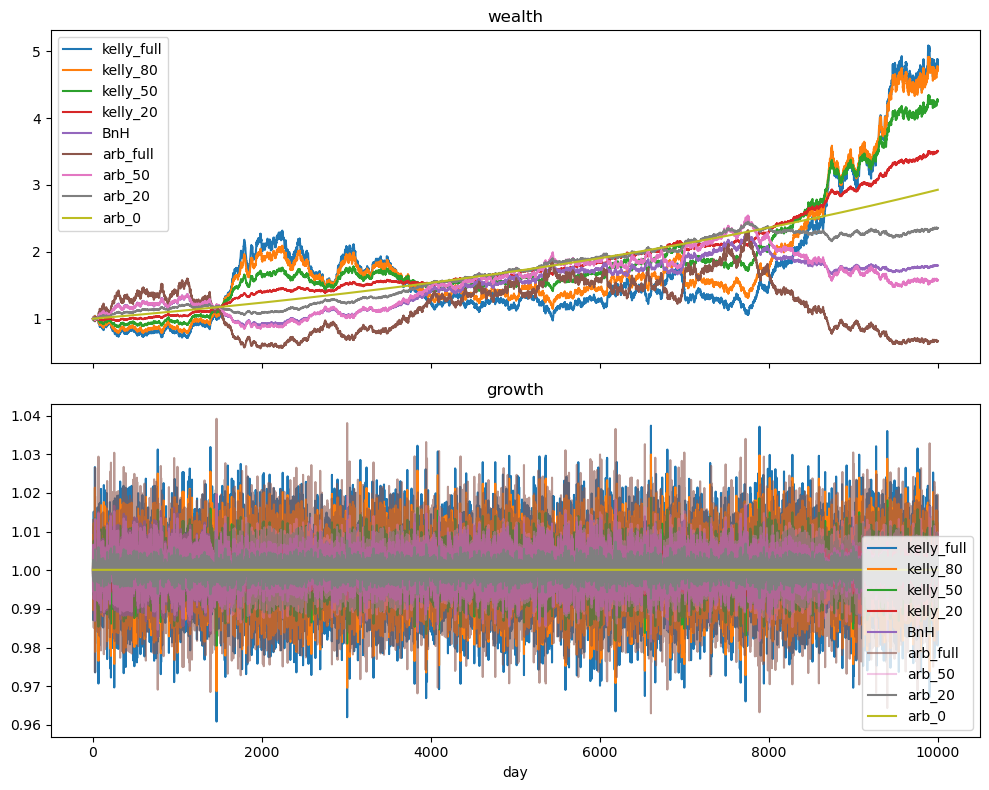

In [225]:
r = ((1+0.04)**(1/365) -1) *np.ones_like(return_array)
return_array = np.random.normal(0,0.01,10000)

kelly_full,growth_kelly_full = kelly( return_array,r,False,1)
kelly_80,growth_kelly_80 = kelly( return_array,r,False,0.8)
kelly_50,growth_kelly_50 = kelly( return_array,r,False,0.5)
kelly_20,growth_kelly_20 = kelly( return_array,r,False,0.2)
BnH_array,growth_BnH = BnH(return_array,r)
arb_full, growth_arb_full=arbitrary(return_array,r,1)
arb_50, growth_arb_50=arbitrary(return_array,r,0.5)
arb_20, growth_arb_20=arbitrary(return_array,r,0.2)
arb_0, growth_arb_0=arbitrary(return_array,r,0)

fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,8))

ax[0].plot(kelly_full,label="kelly_full")
ax[0].plot(kelly_80,label="kelly_80")
ax[0].plot(kelly_50,label="kelly_50")
ax[0].plot(kelly_20,label="kelly_20")
ax[0].plot(BnH_array,label="BnH")
ax[0].plot(arb_full,label="arb_full")
ax[0].plot(arb_50,label="arb_50")
ax[0].plot(arb_20,label="arb_20")
ax[0].plot(arb_0,label="arb_0")
ax[0].set_title('wealth')

ax[1].plot(growth_kelly_full,label="kelly_full")
ax[1].plot(growth_kelly_80,label="kelly_80")
ax[1].plot(growth_kelly_50,label="kelly_50")
ax[1].plot(growth_kelly_20,label="kelly_20")
ax[1].plot(growth_BnH,label="BnH")
ax[1].plot(growth_arb_full,label="arb_full",alpha=0.6)
ax[1].plot(growth_arb_50,label="arb_50",alpha=0.4)
ax[1].plot(growth_arb_20,label="arb_20")
ax[1].plot(growth_arb_0,label="arb_0")
ax[0].legend()
ax[1].legend()
ax[1].set_title('growth')
ax[1].set_xlabel('day')
plt.tight_layout()

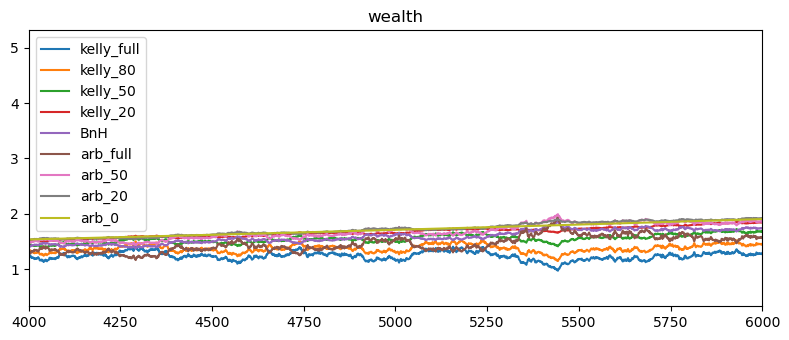

In [231]:
plt.figure(figsize=(8,3.5))
plt.plot(kelly_full,label="kelly_full")
plt.plot(kelly_80,label="kelly_80")
plt.plot(kelly_50,label="kelly_50")
plt.plot(kelly_20,label="kelly_20")
plt.plot(BnH_array,label="BnH")
plt.plot(arb_full,label="arb_full")
plt.plot(arb_50,label="arb_50")
plt.plot(arb_20,label="arb_20")
plt.plot(arb_0,label="arb_0")
plt.title('wealth')

plt.legend()
plt.xlim(4000,6000)
plt.tight_layout()

From the graph, we can see that full kelly gives the largest wealth in the end, but its fluctuation of growth is also very large. Furthermore, in some range, full kelly has even the worst performance compared with others
Also, it seems that BnH strategy is even worst than arb_0 (deposits all in the bank).

### Backtest
Here we use ETF daily price  and US Treasury rate (one month maturity) from 2017/8/17 to 2023/10/30. We consider the time interval with length 90 days for computing the moving average, variance and updating the optimal allocation $f^*$.

In [38]:
rate = pd.read_csv('input data/Treasury_data.csv')

In [27]:
from download_binance import * 
symbols = ["ETH"]
period = "1d"
start = datetime.datetime(2017, 8,  17, 0, 0)
end   = datetime.datetime(2023, 10, 26, 0, 0)

for i, symbol in enumerate( symbols[:] ):

    print(f"Begin downloading: H1-{symbol}")
    df = get_data_since(symbol, start, end, period )
    print(f"Download completed: H1-{symbol}")

Begin downloading: H1-ETH
Download completed: H1-ETH


In [30]:
time = np.array([df.loc[t,'timestamp'] for t in range( len(df['timestamp']) ) ])
window = 90
df['price']=(df["open"]+df["close"])/2
df['returns']= np.log(df['price'])-np.log(df['price']).shift(1)
df['mean']=df['returns'].rolling(window).mean()
df['std']=df['returns'].rolling(window).std()

price_array = df.loc[:,'price'].values
return_array = df.loc[window:,'returns'].values
mean_array= df.loc[:,'mean'].dropna().values
std_array= df.loc[:,'std'].dropna().values


Since the dates of price data and treasury rates data doesn't match, we fill the missing data by the last values before the missing dates. Also, the rates w.r.t monthly return. We also need to change it to the rates w.r.t daily return.

In [39]:
from datetime import datetime
rate['date']=pd.to_datetime(rate['date']) #change str to datetime
rate.set_index('date',inplace = True) #change index to 'date'

df1=rate.resample('D').last().ffill()
add_date = pd.date_range(start='2023-10-27', end='2023-10-30')
df2= pd.DataFrame({'date':add_date , '1m':[5.57]*len(add_date)})
df2.set_index('date',inplace = True) 
df3=pd.concat([df1,df2])
df3['1m']=df3['1m']/100 #change the unit to %
df3['1d']= (1+df3['1m'])**(1/30) -1

rate_array = df3.loc[:,'1d'].values

#### Plot of price and rate

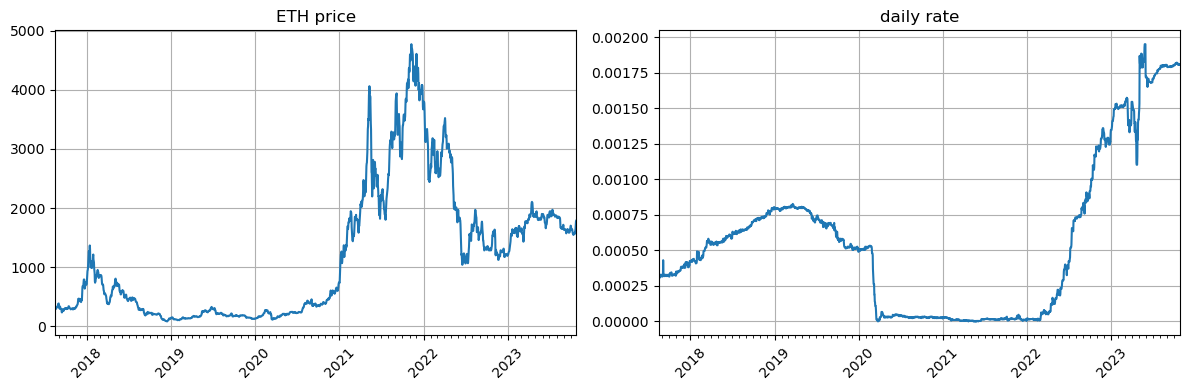

In [40]:
from matplotlib.dates import *
fig,ax = plt.subplots(1,2,figsize=(12,4))
for i in [0,1] :
    if i == 0:
        ax[i].plot(time,price_array)
        ax[i].set_title("ETH price")
    else:
        ax[i].plot(time,rate_array)
        ax[i].set_title("daily rate")
    ax[i].tick_params(axis='x',rotation=45)
    ax[i].xaxis.set_minor_locator(MonthLocator())
    ax[i].set_xlim(start,end)
    ax[i].grid()

plt.tight_layout()

In [41]:
#defining new kelly function that upadating the fraction f_opt
def kelly_updating(return_array,mean_array,std_array,rate_array,kelly_cap,kelly_frac):
    wealth_array = np.ones(len(return_array)+1)
    growth_array = np.zeros_like(return_array)
    f_opt= np.zeros_like(return_array)
    for s in range(len(return_array)):
        mu= mean_array[s]
        var= std_array[s]**2
        if kelly_cap == False: #no restricion for leverage
            f_opt[s] = (mu-rate_array[s])/var *kelly_frac  #allow shorting , f_opt can be negative
        else:
            f_opt[s] = min((mu-rate_array[s])/var ,kelly_cap)*kelly_frac
        growth_array[s] = (1+f_opt[s]*return_array[s] + (1-f_opt[s])*rate_array[s])
        wealth_array[s+1] = wealth_array[s]*growth_array[s]
    return wealth_array,growth_array,f_opt

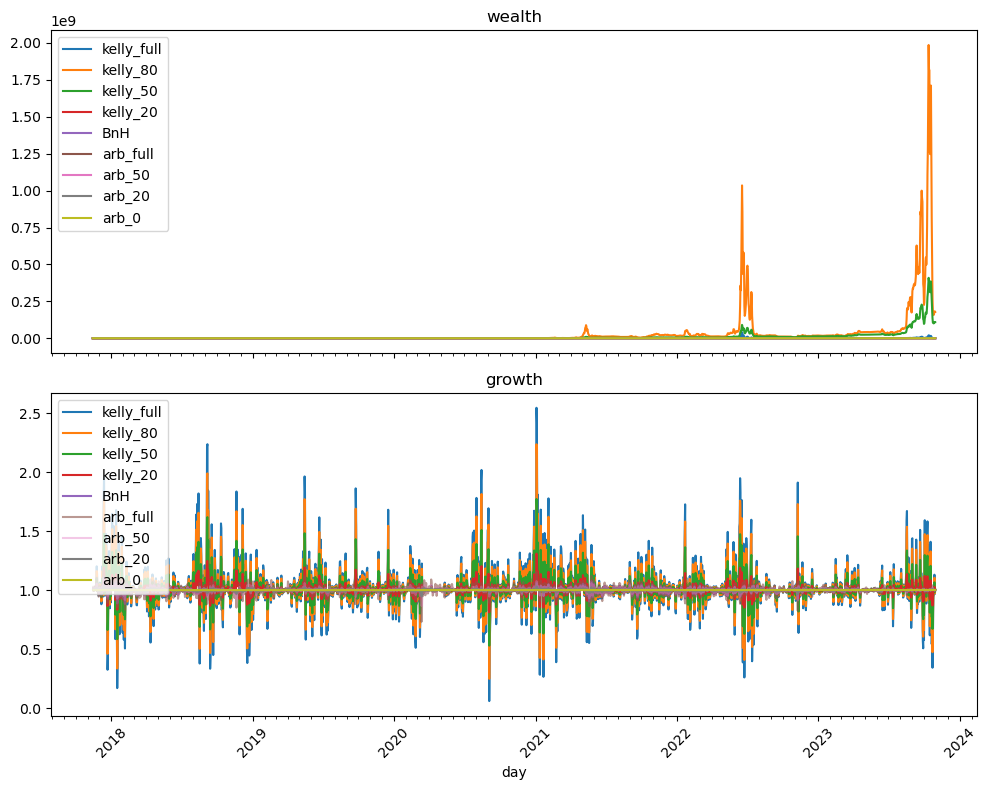

In [56]:
kelly_full,growth_kelly_full,f_full = kelly_updating(return_array,mean_array,std_array,rate_array,False,1)
kelly_80,growth_kelly_80,f_80 = kelly_updating( return_array,mean_array,std_array,rate_array,False,0.8)
kelly_50,growth_kelly_50,f_50 = kelly_updating( return_array,mean_array,std_array,rate_array,False,0.5)
kelly_20,growth_kelly_20,f_20 = kelly_updating( return_array,mean_array,std_array,rate_array,False,0.2)
BnH_array,growth_BnH = BnH(return_array,rate_array)
arb_full, growth_arb_full=arbitrary(return_array,rate_array,1)
arb_50, growth_arb_50=arbitrary(return_array,rate_array,0.5)
arb_20, growth_arb_20=arbitrary(return_array,rate_array,0.2)
arb_0, growth_arb_0=arbitrary(return_array,rate_array,0)

fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,8))

ax[0].plot(time[window-1:],kelly_full,label="kelly_full")
ax[0].plot(time[window-1:],kelly_80,label="kelly_80")
ax[0].plot(time[window-1:],kelly_50,label="kelly_50")
ax[0].plot(time[window-1:],kelly_20,label="kelly_20")
ax[0].plot(time[window-1:],BnH_array,label="BnH")
ax[0].plot(time[window-1:],arb_full,label="arb_full")
ax[0].plot(time[window-1:],arb_50,label="arb_50")
ax[0].plot(time[window-1:],arb_20,label="arb_20")
ax[0].plot(time[window-1:],arb_0,label="arb_0")
ax[0].set_title('wealth')

ax[1].plot(time[window:],growth_kelly_full,label="kelly_full")
ax[1].plot(time[window:],growth_kelly_80,label="kelly_80")
ax[1].plot(time[window:],growth_kelly_50,label="kelly_50")
ax[1].plot(time[window:],growth_kelly_20,label="kelly_20")
ax[1].plot(time[window:],growth_BnH,label="BnH")
ax[1].plot(time[window:],growth_arb_full,label="arb_full",alpha=0.6)
ax[1].plot(time[window:],growth_arb_50,label="arb_50",alpha=0.4)
ax[1].plot(time[window:],growth_arb_20,label="arb_20")
ax[1].plot(time[window:],growth_arb_0,label="arb_0")
ax[1].tick_params(axis='x',rotation=45)
ax[1].xaxis.set_minor_locator(MonthLocator())
ax[0].legend()
ax[1].legend()
ax[1].set_title('growth')
ax[1].set_xlabel('day')
plt.tight_layout()

We see that this time kelly_80 wins in the end. Note that using kelly_80, terminal wealth is $10^9$ times initial wealth! Totally outperforms others. The below shows the plot $f_{opt}$ vs time. One can see that leverages (both long and short) is extreme high for  kelly_fulland kelly_80.

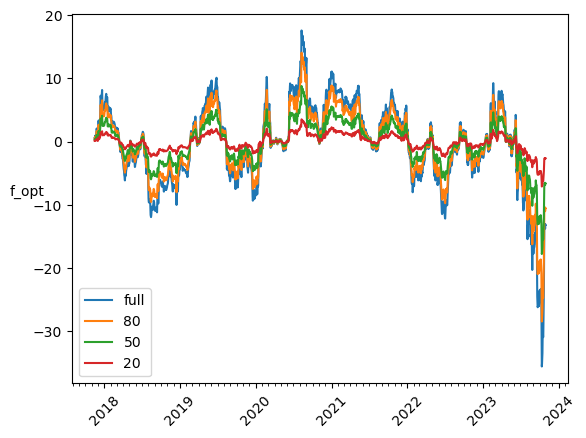

In [63]:
fig,ax=plt.subplots()
ax.plot(time[window:],f_full,label='full')
ax.plot(time[window:],f_80,label='80')
ax.plot(time[window:],f_50,label='50')
ax.plot(time[window:],f_20,label='20')
ax.tick_params(axis='x',rotation=45)
ax.xaxis.set_minor_locator(MonthLocator())
ax.set_ylabel('f_opt',rotation=0)
ax.legend()

The log plot shows that kelly_full falls behind kelly_80 at $2018$. From the 

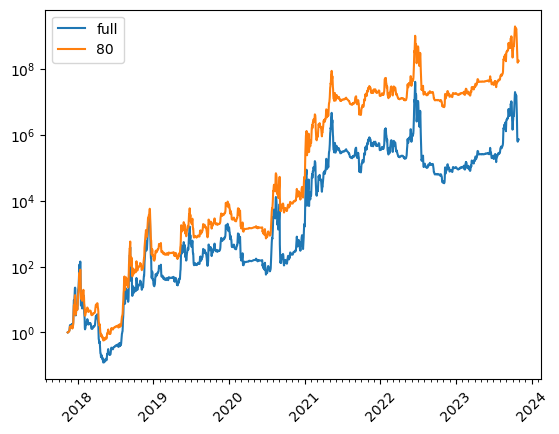

In [62]:
fig,ax = plt.subplots()
ax.plot(time[window-1:],kelly_full,label='full')
ax.plot(time[window-1:],kelly_80,label='80')
ax.set_yscale('log')
ax.tick_params(axis='x',rotation=45)
ax.xaxis.set_minor_locator(MonthLocator())
ax.legend()